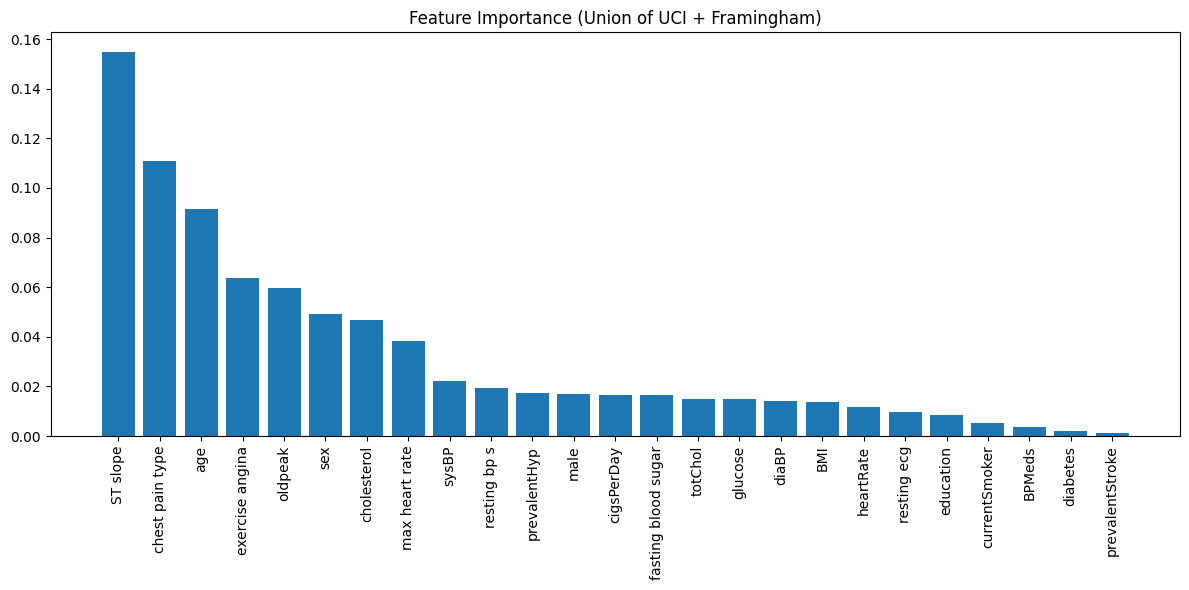

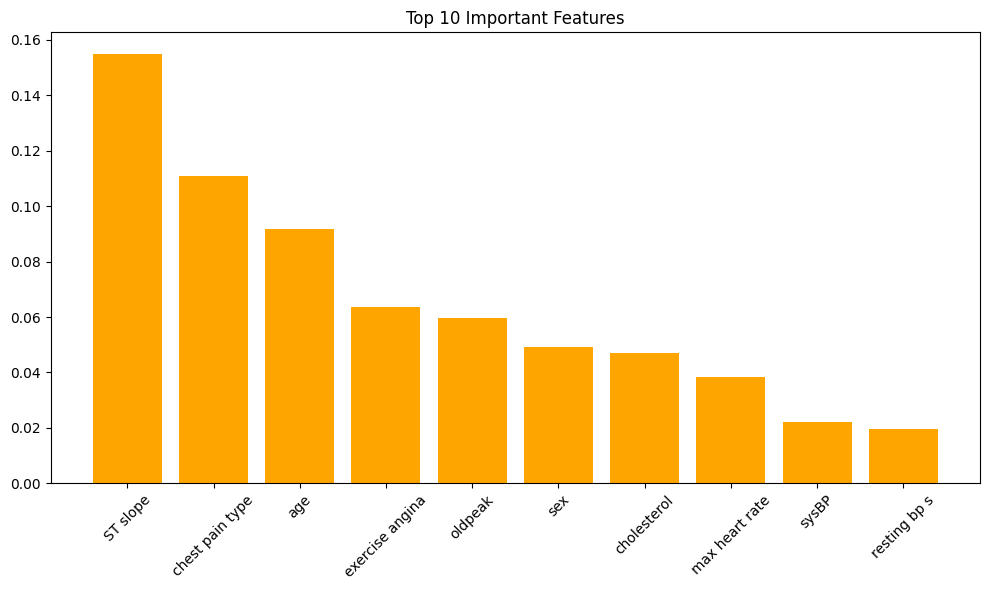

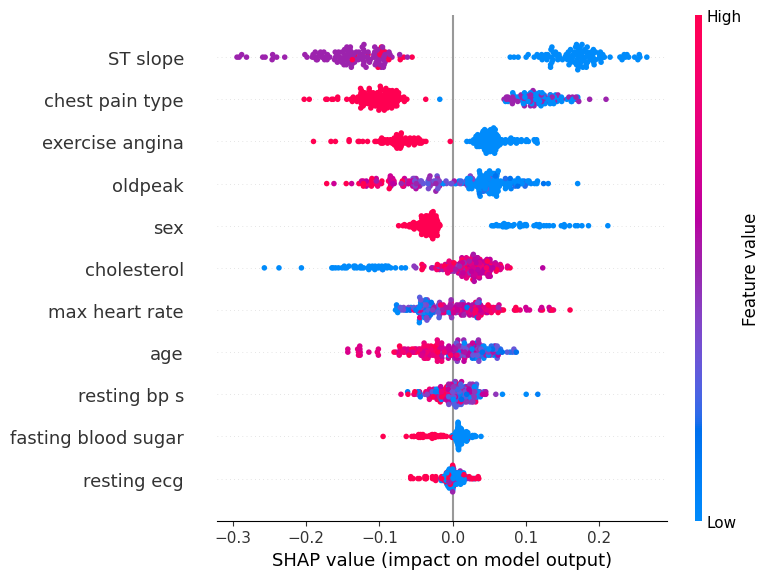

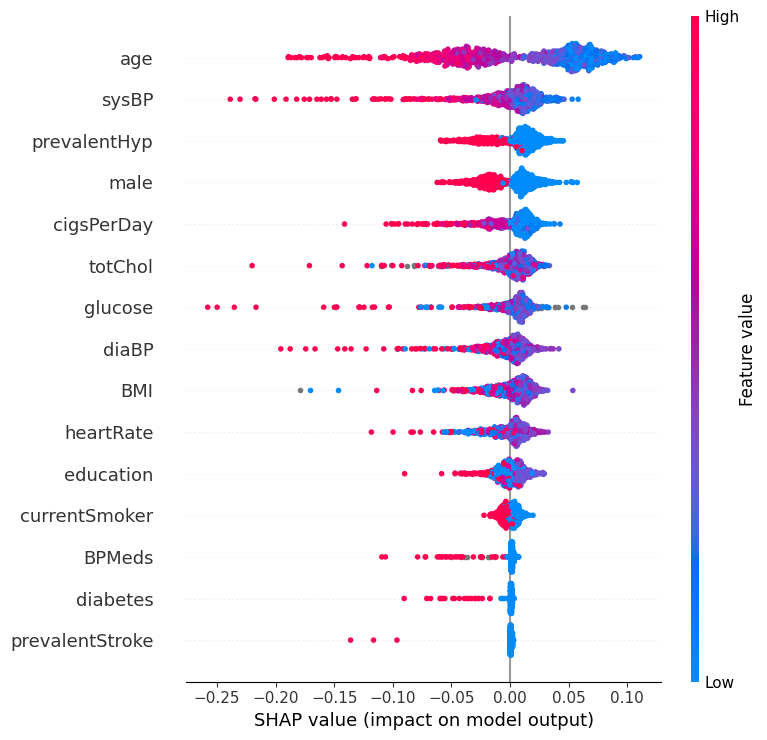


Top 10 Features (Union):
            feature  importance_uci  importance_fram  aggregate_importance
2          ST slope        0.155010         0.000000              0.155010
4   chest pain type        0.110808         0.000000              0.110808
3               age        0.038142         0.053544              0.091686
11  exercise angina        0.063770         0.000000              0.063770
17          oldpeak        0.059580         0.000000              0.059580
22              sex        0.049084         0.000000              0.049084
5       cholesterol        0.046890         0.000000              0.046890
16   max heart rate        0.038347         0.000000              0.038347
23            sysBP        0.000000         0.021993              0.021993
20     resting bp s        0.019550         0.000000              0.019550


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load datasets
uci = pd.read_csv("uci_combined.csv")
fram = pd.read_csv("framingham.csv")

# Split features and target
uci_X = uci.drop("target", axis=1)
uci_y = uci["target"]
fram_X = fram.drop("TenYearCHD", axis=1)
fram_y = fram["TenYearCHD"]

# Train/test split
uci_X_train, uci_X_test, uci_y_train, uci_y_test = train_test_split(
    uci_X, uci_y, test_size=0.2, random_state=42, stratify=uci_y
)
fram_X_train, fram_X_test, fram_y_train, fram_y_test = train_test_split(
    fram_X, fram_y, test_size=0.2, random_state=42, stratify=fram_y
)

# Scale
scaler_uci = StandardScaler()
uci_X_train_scaled = pd.DataFrame(
    scaler_uci.fit_transform(uci_X_train), columns=uci_X.columns, index=uci_X_train.index
)
uci_X_test_scaled = pd.DataFrame(
    scaler_uci.transform(uci_X_test), columns=uci_X.columns, index=uci_X_test.index
)

scaler_fram = StandardScaler()
fram_X_train_scaled = pd.DataFrame(
    scaler_fram.fit_transform(fram_X_train), columns=fram_X.columns, index=fram_X_train.index
)
fram_X_test_scaled = pd.DataFrame(
    scaler_fram.transform(fram_X_test), columns=fram_X.columns, index=fram_X_test.index
)

# Train Random Forest models
uci_model = RandomForestClassifier(random_state=42).fit(uci_X_train_scaled, uci_y_train)
fram_model = RandomForestClassifier(random_state=42).fit(fram_X_train_scaled, fram_y_train)

# SHAP values
explainer_uci = shap.TreeExplainer(uci_model)
shap_values_uci = explainer_uci.shap_values(uci_X_test_scaled)
if isinstance(shap_values_uci, list):
    shap_values_uci = shap_values_uci[1]
shap_values_uci = np.array(shap_values_uci)
if shap_values_uci.ndim == 3:
    shap_values_uci = shap_values_uci[:, :, 0]  # collapse outputs

explainer_fram = shap.TreeExplainer(fram_model)
shap_values_fram = explainer_fram.shap_values(fram_X_test_scaled)
if isinstance(shap_values_fram, list):
    shap_values_fram = shap_values_fram[1]
shap_values_fram = np.array(shap_values_fram)
if shap_values_fram.ndim == 3:
    shap_values_fram = shap_values_fram[:, :, 0]

# SHAP-based importance (1D arrays now)
uci_importance = pd.DataFrame({
    "feature": uci_X.columns,
    "importance_uci": abs(shap_values_uci).mean(axis=0)
})
fram_importance = pd.DataFrame({
    "feature": fram_X.columns,
    "importance_fram": abs(shap_values_fram).mean(axis=0)
})

# Union of features
union_importance = pd.merge(uci_importance, fram_importance, on="feature", how="outer").fillna(0)
union_importance["aggregate_importance"] = union_importance["importance_uci"] + union_importance["importance_fram"]
union_importance = union_importance.sort_values("aggregate_importance", ascending=False)

# Plot all features
plt.figure(figsize=(12, 6))
plt.bar(union_importance["feature"], union_importance["aggregate_importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance (Union of UCI + Framingham)")
plt.tight_layout()
plt.show()

# Top 10 features
top10 = union_importance.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10["feature"], top10["aggregate_importance"], color="orange")
plt.xticks(rotation=45)
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()

# SHAP summary plots
shap.summary_plot(shap_values_uci, uci_X_test_scaled, feature_names=uci_X.columns, show=True)
shap.summary_plot(shap_values_fram, fram_X_test_scaled, feature_names=fram_X.columns, show=True)

# Print top 10
print("\nTop 10 Features (Union):")
print(top10)
